<a href="https://colab.research.google.com/github/dhtdean/IFDN/blob/master/Yitao_ManTraNet_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IFDN**: Image forgery detection netwrok

***
This is image forgery detection network adapted from ManTraNet (See citation below). We intend to improve the network by allowing for detection of style transferred detection. 

```
  @inproceedings{Wu2019ManTraNet,
      title={ManTra-Net: Manipulation Tracing Network For Detection And Localization of Image ForgeriesWith Anomalous Features},
      author={Yue Wu, Wael AbdAlmageed, and Premkumar Natarajan},
      journal={The IEEE Conference on Computer Vision and Pattern Recognition (CVPR)},
      year={2019}
  }
```

***

# 1. Download the IFDN Repo

In [1]:
!git clone https://github.com/dhtdean/IFDN.git


Cloning into 'ManTraNet'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 202 (delta 26), reused 157 (delta 3), pack-reused 0
Receiving objects: 100% (202/202), 139.99 MiB | 12.65 MiB/s, done.
Resolving deltas: 100% (26/26), done.


# 2. Import Dependent Libs and Set Paths

In [0]:
import os
import numpy as np 
import cv2
import requests
import sys

from PIL import Image
from io import BytesIO
from matplotlib import pyplot


In [0]:
manTraNet_root = './ManTraNet/'
manTraNet_srcDir = os.path.join( manTraNet_root, 'src' )
sys.path.insert( 0, manTraNet_srcDir )
manTraNet_modelDir = os.path.join( manTraNet_root, 'pretrained_weights' )

# 3. Load Sample Data 

In [4]:
manTraNet_dataDir = os.path.join( manTraNet_root, 'data' )
sample_file = os.path.join( manTraNet_dataDir, 'samplePairs.csv' )
assert os.path.isfile( sample_file ), "ERROR: can NOT find sample data, check `manTraNet_root`"
with open( sample_file ) as IN :
    sample_pairs = [line.strip().split(',') for line in IN.readlines() ]
L = len(sample_pairs)
print("INFO: in total, load", L, "samples")
    
def get_a_random_pair() :
    idx = np.random.randint(0,L)
    return ( os.path.join( manTraNet_dataDir, this ) for this in sample_pairs[idx] ) 

INFO: in total, load 72 samples


# 4. Load A Pretrained ManTraNet Model

In [5]:
import modelCore
manTraNet = modelCore.load_pretrain_model_by_index( 4, manTraNet_modelDir )

Using TensorFlow backend.




INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True











In [6]:
# ManTraNet Architecture 
print(manTraNet.summary(line_length=120))

Model: "sigNet"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
img_in (InputLayer)                    (None, None, None, 3)      0                                                     
________________________________________________________________________________________________________________________
Featex (Model)                         (None, None, None, 256)    3675181       img_in[0][0]                            
________________________________________________________________________________________________________________________
outlierTrans (Conv2D)                  (None, None, None, 64)     16384         Featex[1][0]                            
________________________________________________________________________________________________________________________
bnorm (BatchNorm

In [7]:
# Image Manipulation Classification Network
IMCFeatex = manTraNet.get_layer('Featex')
print(IMCFeatex.summary(line_length=120))

Model: "Featex"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
image_in (InputLayer)                                 (None, None, None, 3)                           0                 
________________________________________________________________________________________________________________________
b1c1 (CombinedConv2D)                                 (None, None, None, 16)                          525               
________________________________________________________________________________________________________________________
b1c2 (Conv2DSymPadding)                               (None, None, None, 32)                          4640              
________________________________________________________________________________________________________________________
b2c1 (Conv2DSymP

# 5. Retrain the model with added data

## test the size of input and output

In [10]:
# just test the size of X and Y
X_train1 = np.random.rand(10, 64, 64, 3)
X_train1 = X_train1 * 2 - 1
Y_train1 = np.random.rand(10, 64, 64, 1)
single_gpu_model = modelCore.create_model(2,False, [7, 15, 31])
single_gpu_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
single_gpu_model.fit(X_train1, Y_train1, epochs=2, batch_size=3)

INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
10/10 [==============================] - 6s 567ms/step - loss: 0.6990 - acc: 0.0000e+00
Epoch 2/2
10/10 [==============================] - 1s 96ms/step - loss: 0.6931 - acc: 0.0000e+00


## add input data

In [0]:
import os
import glob
m = 1
X_train = np.zeros((m,1080,1920,3))
Y_train = np.zeros((m,1080,1920,1))

k = 0
for filename in glob.glob('*.TIF'):
    X_train[k] = cv2.imread(filename) / 255 * 2 - 1
k = 0
for filename in glob.glob('*.PNG'):
    Y_train[k] = np.expand_dims(cv2.imread(filename, 0), axis = -1) / 255

## print input figure and summary of NN

(1, 1080, 1920, 3)
(1, 1080, 1920, 1)


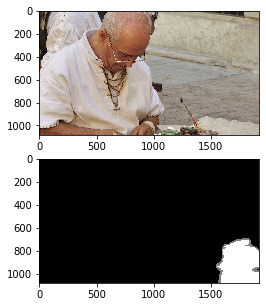

Model: "sigNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Featex (Model)                  (None, None, None, 2 3675181     img_in[0][0]                     
__________________________________________________________________________________________________
outlierTrans (Conv2D)           (None, None, None, 6 16384       Featex[1][0]                     
__________________________________________________________________________________________________
bnorm (BatchNormalization)      (None, None, None, 6 128         outlierTrans[0][0]               
_____________________________________________________________________________________________

In [41]:
print(X_train.shape)
print(Y_train.shape)
import matplotlib.pyplot as plt
img_mask = read_rgb_image('r0f2e6baft.PNG')
img_forge = read_rgb_image('r0f2e6baft.TIF')
plt.figure( figsize=(15,5) )
plt.subplot(2,1,1)
plt.imshow(img_forge)
plt.subplot(2,1,2)
plt.imshow(img_mask)
plt.show()
model = manTraNet
# freeze first 5 layers
for layer in model.layers[:5]:
    layer.trainable = False
print(model.summary())

## train model

In [42]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model.train_on_batch(X_train,Y_train)

[0.23758823, 0.941318]

## print the predicted groundtruth

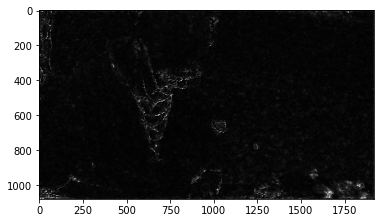

In [38]:
import matplotlib.pyplot as plt
forecast = model.predict(X_train)
plt.figure()
plt.imshow(forecast[0,:,:,0], cmap='gray')
plt.show()